In [1]:
import sortednp as snp
from sortedcontainers import SortedSet
import numpy as np
from numpy import array
from bitarray import bitarray
import timeit
from realkd.search import Context as OriginalContext
from realkd.search import Context as SimplificationPatchedContext
from realkd.search import Context as ExtentCreationPatchedContext
from realkd.search import Context as BothPatchedContext
from realkd.datasets import noisy_parity

In [2]:
def patched_greedy_simplification(self, intent, extent):
    to_cover = SortedSet(range(self.m)).difference(SortedSet(extent))
    available = list(range(len(intent)))
    covering = [SortedSet(range(self.m)).difference(SortedSet(self.extents[j])) for j in intent]
    result = []
    while to_cover:
        j = max(available, key=lambda i: len(covering[i]))
        result += [intent[j]]
        available.remove(j)
        to_cover -= covering[j]
        for l in available:
            covering[l] -= covering[j]

    return result

def get_bit_array_from_indexes(indexes, length):
    result = bitarray(length)
    result.setall(0)
    for index in indexes:
        result[index] = 1
    return result

def patched___init__(self, attributes, objects, sort_attributes=True):
    self.attributes = attributes
    self.objects = objects
    self.n = len(attributes)
    self.m = len(objects)
    # for now we materialise the whole binary relation; in the future can be on demand
    # self.extents = [SortedSet([i for i in range(self.m) if attributes[j](objects[i])]) for j in range(self.n)]
    self.extents = [array([i for i in range(self.m) if attributes[j](objects[i])], dtype='int64') for j in range(self.n)]
    self.bit_extents = [get_bit_array_from_indexes(self.extents[j], self.m) for j in range(self.n)]

    # sort attribute in ascending order of extent size
    if sort_attributes:
        attribute_order = list(sorted(range(self.n), key=lambda i: len(self.extents[i])))
        self.attributes = [self.attributes[i] for i in attribute_order]
        self.extents = [self.extents[i] for i in attribute_order]
        self.bit_extents = [self.bit_extents[i] for i in attribute_order]

    # switches
    self.crit_propagation = True

    # stats
    self.popped = 0
    self.created = 0
    self.avg_created_length = 0
    self.rec_crit_hits = 0
    self.crit_hits = 0
    self.del_bnd_hits = 0
    self.clo_hits = 0
    self.non_lexmin_hits = 0
    self.bnd_post_children_hits = 0
    self.bnd_immediate_hits = 0

SimplificationPatchedContext.greedy_simplification = patched_greedy_simplification
ExtentCreationPatchedContext.__init__ = patched___init__
BothPatchedContext.__init__ = patched___init__
BothPatchedContext.greedy_simplification = patched_greedy_simplification

In [8]:
ms_to_plot = np.arange(1000, 10000, 1000)
densities_to_plot = [2/x for x in range(2, 12, 1)][::-1]

LOOPS_PER_RUN = 1
NUM_REPEATS = 5
RUNS_PER_REPEAT = 3
BASE_N = 90_000

benchmark_configs = [
  {
    'name': 'benchmarks_balanced',
    'display': {
      'title': 'Array A: n elements, Array B: n elements',
      'xlabel': '$n$ (density = 1/3)'
    },
    'iterator': ms_to_plot,
    'config': {
      'm': '$i'
    }
  },
]

benchmark_results = {}

RNG = np.random.default_rng(0)

def generate_test_data(n, i):
  return noisy_parity(n, d=100, random_seed=i)

def original(data):
    context = OriginalContext.from_df(data)
    simplified = context.greedy_simplification([1,3,4], context.extension([1,3,4]))

def simplificationpatched(data):
    context = SimplificationPatchedContext.from_df(data)
    simplified = context.greedy_simplification([1,3,4], context.extension([1,3,4]))

def extentspatched(data):
    context = ExtentCreationPatchedContext.from_df(data)
    simplified = context.greedy_simplification([1,3,4], context.extension([1,3,4]))

def bothpatched(data):
    context = BothPatchedContext.from_df(data)
    simplified = context.greedy_simplification([1,3,4], context.extension([1,3,4]))
  
label_to_colors = {
  'original': 'green',
  'simplificationpatched': 'purple',
  'extentspatched': 'black',
  'bothpatched': 'yellow'
}

for benchmark in benchmark_configs:
  print(benchmark['name'])
  benchmark_results[benchmark['name']] = {
    'original': {},
    'simplificationpatched': {},
    'extentspatched': {},
    'bothpatched': {}
  }
  for i, m in enumerate(benchmark['iterator']):
    for method in benchmark_results[benchmark['name']].keys():
      print(f'm={m}, method={method}:')
      timeresults = []
      for _ in range(NUM_REPEATS):
        test_data, y = generate_test_data(m, i)
        timeresults.append(min(timeit.repeat(f'{method}(test_data)', repeat=RUNS_PER_REPEAT, number=LOOPS_PER_RUN, globals=globals())))
      benchmark_results[benchmark['name']][method][m] = timeresults

benchmarks_balanced
m=1000, method=original:


KeyboardInterrupt: 

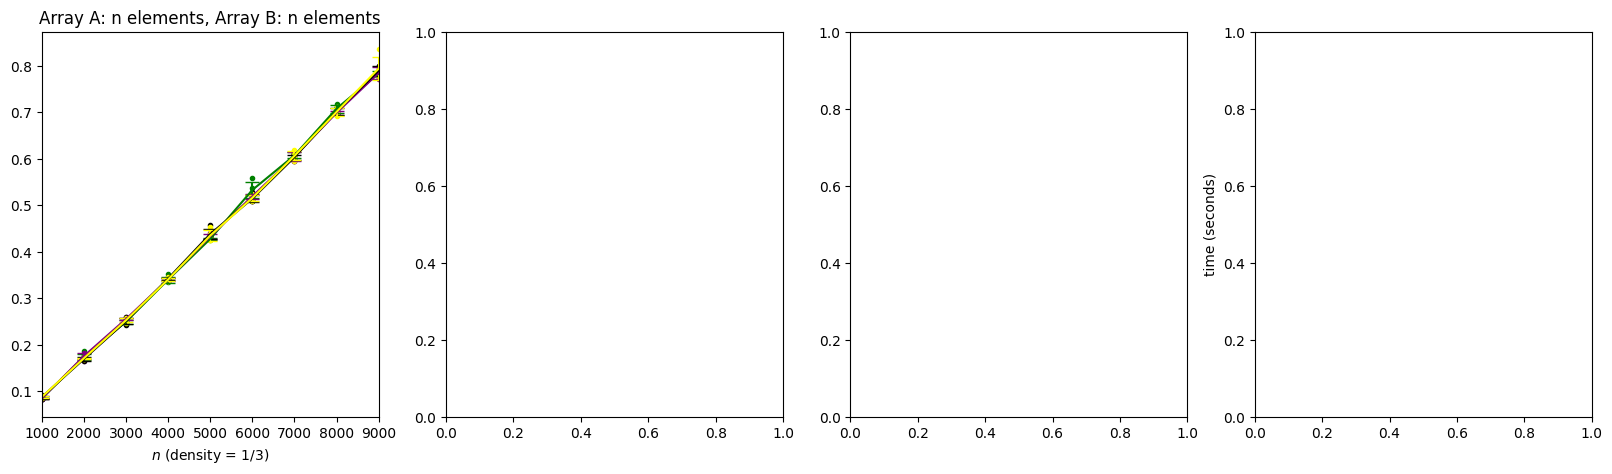

In [6]:

from statistics import mean, stdev
from matplotlib.markers import MarkerStyle
import matplotlib.pyplot as plt
from numpy import average
plt.subplots(1, 4, figsize=(20, 5))

plt.ylabel('time (seconds)')
for i, benchmark in enumerate(benchmark_configs):
  plt.subplot(1, 4, i+1)
  plt.xlim(benchmark['iterator'][0], benchmark['iterator'][-1])
  plt.title(benchmark['display']['title'])
  plt.xlabel(benchmark['display']['xlabel'])
  for label, time_result in benchmark_results[benchmark['name']].items():
    for i in benchmark['iterator']:
      plt.scatter([i]*NUM_REPEATS, time_result[i], c=label_to_colors[label], marker='.')
    plt.errorbar(benchmark['iterator'], [mean(time_result[i]) for i in benchmark['iterator']], yerr=[stdev(time_result[i]) for i in benchmark['iterator']], marker='', capsize=5.0, label=label, c=label_to_colors[label])

plt.show()